<a href="https://colab.research.google.com/github/MachtaYassine/MonteCarlo_2A_ENSAE/blob/main/charles_monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definition of the functions

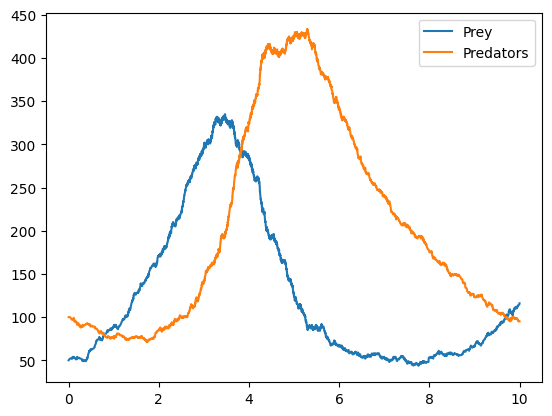

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# define the reaction rates and initial state of the system
theta1 = 1
theta2 = 0.005
theta3 = 0.6
theta = [theta1, theta2, theta3]
x0 = np.array([50, 100])

# Define the probability of each update
def a1(theta, x):
    return max(0, theta[0]) * x[0]

def a2(theta, x):
    return max(0, theta[1]) * x[0] * x[1]

def a3(theta, x):
    return max(0, theta[2]) * x[1]

# Update the system using Gillespie's algorithm
def time_update(theta, c):
    x = c.copy()
    if x[0]>500*x[1]: # Arbitrary criterion for the algorithm to end, final state of the system
        return x, 10e-4
    a = np.array([a1(theta,x),a2(theta,x),a3(theta,x)])
    a0 = np.sum(a)
    r1= np.random.uniform()
    if a0>0:
        tau = -(1/a0)*np.log(r1) # Time since last update
    else:
        tau = float('inf')
    # Choose what the next update will be, we only consider strict updates (when the system evolves)
    rand = np.random.uniform()
    if rand*a0>0 and rand*a0<a[2]:
        x[1] -= 1
    elif rand*a0>0 and rand*a0<a[2]+a[1]:
        x[0] -= 1
        x[1] += 1
    elif rand*a0>0:
        x[0] += 1
    return x, tau

# Simulate data using ABC with Gillespie's algorithm
def collect_data(theta):
    t = 0
    T = period
    t_L = [0]
    x = [x0]
    while t < T:
        X1, tau = time_update(theta, x[-1]) # Get our new data point and the time since the creation of the last data point
        t += tau
        x.append(X1)
        t_L.append(t)
    return x,t_L

# Sample data from a likelihood, taking the parameter, the number of data points and the initial value
period=10
def sample_data(theta,N,x0):
    T = period
    Y = []
    for k in range(N):
        c = x0.copy() # We need to do a copy, otherwise it will change x0 as well
        x = []
        t = 0
        while t < T:
            c, tau = time_update(theta, c) # Sample one new data point
            if tau == float('inf'): # No next update if tau = infinity
                while len(x)<10: # We need to have x of length 10 to make w work
                    x.append(c[0]) # Since the system does not evolve anymore, we put all following data to the terminal value
            else:
                if int(t+tau)-int(t)>0: # We check if we have gotten past the next integer, and we save the corresponding data point (we only keep the first component here)
                    for k in range(int(t+tau)-int(t)):
                        x.append(c[0])
            t += tau
        Y.append(x)
    return Y

x_test,t_L=collect_data(theta)
x_test = np.array(x_test)
plt.plot(t_L,x_test[:, 0], label='Prey')
plt.plot(t_L,x_test[:, 1], label='Predators')
plt.legend()
plt.show()

In [ ]:
# Creation of y, our "real data"
y = sample_data(theta, 1, [50,100])[0]

In [ ]:
# We define the parameters of the simulation, as presented in the paper
theta = [1,0.005,0.6]
theta_tilde = [1,1,1]
sigma = np.diag([0.25, 0.0025, 0.25])
epsilon = 1 
e=np.exp(1)
# Definition of the function p

def p(theta):
    return 100*np.exp(-theta[0]-100*theta[1]-theta[2])

# Definition of the function w, takes a list of 10-arrays [x1, ..., xN] and returns the list [w(x1), ..., w(xN)], which is an element of {0,1}^N

def w(X):
    W = []
    k=0
    for x in X:
        inside = 1
        for i in range(period):
            if np.log(y[i])-np.log(x[i])>epsilon: # Pseudo-distance used in the paper
                inside = 0
        W.append(inside)
    return W


def w_bis(X):
    W = []
    k=0
    for x in X:
        inside = 1
        for i in range(period):
            if x[i]>e*y[i] or x[i]< y[i]/e: # Pseudo-distance used in the paper
                inside = 0
        W.append(inside)
    return W

In [ ]:
# Algorithm 1
def algo_1(theta, sigma, N):
    x0 = [50,100]

    # Step 1
    # We sample nu
    nu = [max(i,0) for i in np.random.multivariate_normal(theta,sigma)] # We take a gaussian perturbation of theta
    # We sample z with respect to the likelihood in nu
    z = sample_data(nu, N, x0)
    X = sample_data(theta, N, x0)
    # Step 2
    u = np.random.uniform()
    # The kernel q is symmetrical in (theta, curly_theta) so the ratio p(theta, nu)/p(nu, theta) is equal to 1
    if u*p(theta)*np.sum(w_bis(X)) < p(nu)*np.sum(w_bis(z)): #Check if our uniform rv is lower than our probability
        return nu
    else:
        return theta

In [ ]:
#Algo 2

def algo_2(theta,sigma,N):
    x0 = [50,100]

    # Step 1
    # We sample nu
    nu = [max(i,0) for i in np.random.multivariate_normal(theta,sigma)] # Gaussian perturbation of theta
    # We sample z with respect to the likelihood in nu
    z = sample_data(nu, N, x0)
    # We sample x with respect to the likelihood in theta
    x = sample_data(theta, N-1, x0)

    # Step 2
    u = np.random.uniform()
    # p(theta, nu) = p(nu, theta) bc the kernel is symmetrical (Gaussian)
    if u*p(theta)*(1+np.sum(w_bis(x))) < p(nu)*np.sum(w_bis(z)): # Check if our uniform rv is lower than our probability
        return nu
    else:
        return theta


In [ ]:
# Algo 3

def algo_3(theta, sigma):
    x0 = [50,100]

    # Step 1
    # We sample nu
    nu = [max(i,0) for i in np.random.multivariate_normal(theta,sigma)] # Gaussian perturbation of theta

    # Step 2
    u = np.random.uniform()
    # p(theta, nu) = p(nu, theta) bc the kernel is symmetrical (Gaussian)
    if u*p(theta)>p(nu): # We check if our uniform rv is lower than our probability
        return theta, 0
    # Step 3
    n = 1
    X = []
    Z = []
    x = sample_data(theta, 1, x0) # We take only one data point
    z = sample_data(nu, 1, x0)
    X.append(x[0])
    Z.append(z[0])
    
    while np.sum(w_bis(X))+np.sum(w_bis(Z))<1: # Condition given in the paper
        x = sample_data(theta, 1, x0) # New data points
        z = sample_data(nu, 1, x0)
        X.append(x[0])
        Z.append(z[0])
        n += 1
        
    # Step 4
    if w_bis(Z)[-1]==1:
        return nu, n # We return the new parameter as well as n, because we want to compute the average value of n
    else:
        return theta, n



### Better than 1 bc we sample progressively, so we gain computation time. Moreover, we only consider a few data points rather than a lot of them, 
### which can on average be better but not at a specific moment (algo 3 considers the first time when x or z is close to y, and checks which one is the closest)

In [ ]:
#Algo 4

def h(theta):
    g=sample_data(theta, 20, x0)

    return np.sum(w_bis(g))/20

def algo_4(theta,sigma):
    x0 = [50,100]

    # Step 1
    # We sample nu
    nu = [max(i,0) for i in np.random.multivariate_normal(theta,sigma)]
    # We compute the probabilities h(theta) and h(nu) of a sample x falling in the ball of radius epsilon and center y
    p_theta=h(theta)
    #print(p_theta)
    p_nu=h(nu)
    #print(p_nu)
    u = np.random.uniform()
    # Justifier l'absence de p(theta, nu) dans les slides car q est symétrique (noyau gaussien)
    if u*p(theta)*p_theta < p(nu)*p_nu:
        return nu
    else:
        return theta

In [ ]:

h([1.3148948154383604, 0, 0.36878031275490847])

KeyboardInterrupt: ignored

In [ ]:
w_bis(sample_data(theta, 20, [50,100]))

[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]

In [ ]:
algo_3(theta, sigma)


([1, 0.005, 0.6], 1)

#Comparison of the algorithms

In [ ]:
from tqdm import tqdm
N = 1
prop1_L = [theta]

for k in tqdm(range(500)):
    prop1 = algo_1(prop1_L[-1], sigma, N)
    prop1_L.append(prop1)
   


In [ ]:
from tqdm import tqdm
N = 1

prop2_L = [theta]

for k in tqdm(range(500)):
    
    prop2 = algo_2(prop2_L[-1], sigma, N)
    prop2_L.append(prop2)
    

In [ ]:
from tqdm import tqdm
N = 1

prop3_L = [theta]

n3_L = []
for k in tqdm(range(500)):
    
    prop3, n  = algo_3(prop3_L[-1], sigma)
   
    prop3_L.append(prop3)
   
    n3_L.append(n)

print(np.mean(n3_L))

  1%|          | 4/500 [00:00<01:00,  8.26it/s]<ipython-input-39-a98340add4ab>:31: RuntimeWarning: divide by zero encountered in log
  if np.log(x[i])-np.log(y[i])>epsilon: # Pseudo-distance used in the paper
100%|██████████| 500/500 [00:18<00:00, 27.06it/s]

1.006


In [ ]:
from tqdm import tqdm
N = 1

prop4_L = [theta]

for k in tqdm(range(500)):
   
    prop4 = algo_4(prop4_L[-1], sigma)
   
    prop4_L.append(prop4)
  

In [ ]:
from tqdm import tqdm
N = 1
prop1_L = [theta]
prop2_L = [theta]
prop3_L = [theta]
prop4_L = [theta]
n3_L = []
for k in tqdm(range(500)):
    prop1 = algo_1(prop1_L[-1], sigma, N)
    prop2 = algo_2(prop2_L[-1], sigma, N)
    prop3, n  = algo_3(prop3_L[-1], sigma)
    # prop4 = algo_4(prop4_L[-1], sigma)
    prop1_L.append(prop1)
    prop2_L.append(prop2)
    prop3_L.append(prop3)
    # prop4_L.append(prop4)
    n3_L.append(n)

print(np.mean(n3_L))

100%|██████████| 500/500 [00:37<00:00, 13.49it/s]

0.642


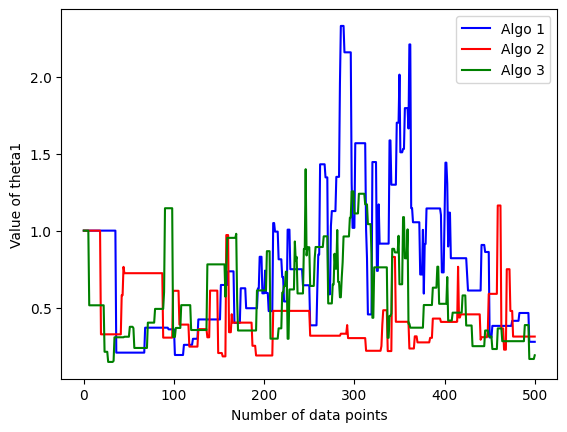

In [ ]:
# Plotting the evolution of theta1 for all algorithms

a = np.arange(0,len(prop1_L),1)
plt.plot(a, np.array(prop1_L)[:,0], color = "blue", markersize = 0.5, label = "Algo 1")
plt.plot(a, np.array(prop2_L)[:,0], color = "red", markersize = 0.5, label = "Algo 2")
plt.plot(a, np.array(prop3_L)[:,0], color = "green", markersize = 0.5, label = "Algo 3")
# plt.plot(a, np.array(prop4_L)[:,0], color = "purple", markersize = 0.5, label = "Algo 4")
plt.xlabel("Number of data points")
plt.ylabel("Value of theta1")
plt.legend()
plt.show()

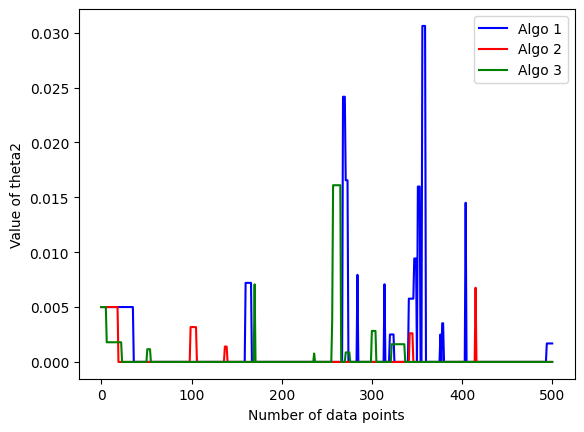

In [ ]:
# Plotting the evolution of theta2 for all algorithms

a = np.arange(0,len(prop1_L),1)
plt.plot(a, np.array(prop1_L)[:,1], color = "blue", markersize = 0.5, label = "Algo 1")
plt.plot(a, np.array(prop2_L)[:,1], color = "red", markersize = 0.5, label = "Algo 2")
plt.plot(a, np.array(prop3_L)[:,1], color = "green", markersize = 0.5, label = "Algo 3")
# plt.plot(a, np.array(prop4_L)[:,1], color = "purple", markersize = 0.5, label = "Algo 4")
plt.xlabel("Number of data points")
plt.ylabel("Value of theta2")
plt.legend()
plt.show()

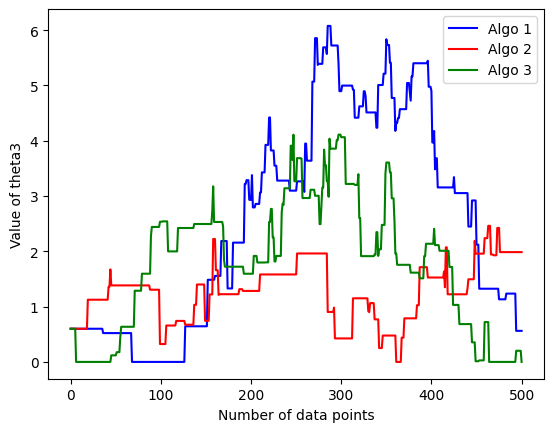

In [ ]:
# Plotting the evolution of theta3 for all algorithms

a = np.arange(0,len(prop1_L),1)
plt.plot(a, np.array(prop1_L)[:,2], color = "blue", markersize = 0.5, label = "Algo 1")
plt.plot(a, np.array(prop2_L)[:,2], color = "red", markersize = 0.5, label = "Algo 2")
plt.plot(a, np.array(prop3_L)[:,2], color = "green", markersize = 0.5, label = "Algo 3")
# plt.plot(a, np.array(prop4_L)[:,2], color = "purple", markersize = 0.5, label = "Algo 4")
plt.xlabel("Number of data points")
plt.ylabel("Value of theta3")
plt.legend()
plt.show()

In [ ]:
# Plotting the evolution of the a posteriori mean for theta3

cum1 = [np.sum(np.array(prop1_L)[:i,2])/i for i in range(1,len(prop1_L))]
cum2 = [np.sum(np.array(prop2_L)[:i,2])/i for i in range(1,len(prop2_L))]
cum3 = [np.sum(np.array(prop3_L)[:i,2])/i for i in range(1,len(prop3_L))]

a = np.arange(0,len(cum1),1)
plt.plot(a, np.array(cum1), color = "blue", markersize = 0.5, label = "Algo 1")
plt.plot(a, np.array(cum2), color = "red", markersize = 0.5, label = "Algo 2")
plt.plot(a, np.array(cum3), color = "green", markersize = 0.5, label = "Algo 3")
# plt.plot(a, np.array(prop4_L)[:,0], color = "purple", markersize = 0.5, label = "Algo 4")
plt.xlabel("Number of data points")
plt.ylabel("Value of the cumulative mean of theta3")
plt.legend()
plt.show()

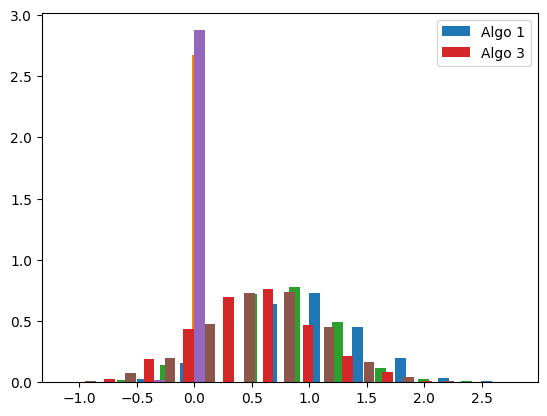

In [ ]:
# Density plots

import matplotlib.pyplot as plt
import numpy as np

# Generate some random data
data1 = np.random.multivariate_normal(prop1, sigma, 1000)
data2 = np.random.multivariate_normal(prop2, sigma, 1000)

# Create the density plot
plt.hist(data1, density=True,  label = "Algo 1")
plt.hist(data2, density=True, label = "Algo 3")
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objs as go
# Generate some random data


trace1 = go.Scatter3d(
    x=prop1_L[:,0],
    y=prop1_L[:,1],
    z=prop1_L[:,2],
    mode='markers',
    marker=dict(
        size=0.5,
        color='red',
        opacity=0.7
    ),
    name='Algo 1'
)

# Create the trace for the second dataset
trace2 = go.Scatter3d(
    x=prop2_L[:,0],
    y=prop2_L[:,1],
    z=prop2_L[:,2],
    mode='markers',
    marker=dict(
        size=0.5,
        color='blue',
        opacity=0.7
    ),
    name='Algo 3'
)

# Create the layout
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create the figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()

In [ ]:
from scipy.stats import gaussian_kde
from scipy.stats import norm

def ess(samples):
    """
    Computes the effective sample size (ESS) of a set of samples
    """
    n = len(samples)
    # Compute the autocorrelation of the samples
    autocorr = np.correlate(samples - np.mean(samples), samples - np.mean(samples), mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    # Compute the variance of the samples
    var = np.var(samples)
    # Compute the ESS
    ess = n / (1 + 2*np.sum(autocorr)/var)
    return ess




# Compute the ESS for each dimension of each sample
ess1 = [ess(prop1_L[:, i]) for i in range(3)]
ess2 = [ess(prop3_L[:, i]) for i in range(3)]

# Print the results
print("ESS for Algo1:", ess1)
print("ESS for Algo3:", ess2)
print([ess1[i]<ess2[i] for i in range(3)])


ESS for Algo1: [0.9998000399920023, 0.9998000399920023, 0.9998000399920033]
ESS for Algo3: [0.9998000399920011, 0.9998000399920025, 0.9998000399920013]
[False, True, False]
